In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CC_Thesis_DP/datasets/imagenet/val_images.zip", 'r')
#zip_ref = zipfile.ZipFile("/content/drive/My Drive/Research/Thesis/CC_Thesis_DP/datasets/imagenet/val_images.zip", 'r')

for i in range(50000):

  if i <45000:
    zip_ref.extract(zip_ref.infolist()[i], path = "/content/imagenet/Train")
  else:
    zip_ref.extract(zip_ref.infolist()[i], path = "/content/imagenet/Test")

#zip_ref.extractall("/content/CC_Thesis_DP/datasets/imagenet/")
zip_ref.close()

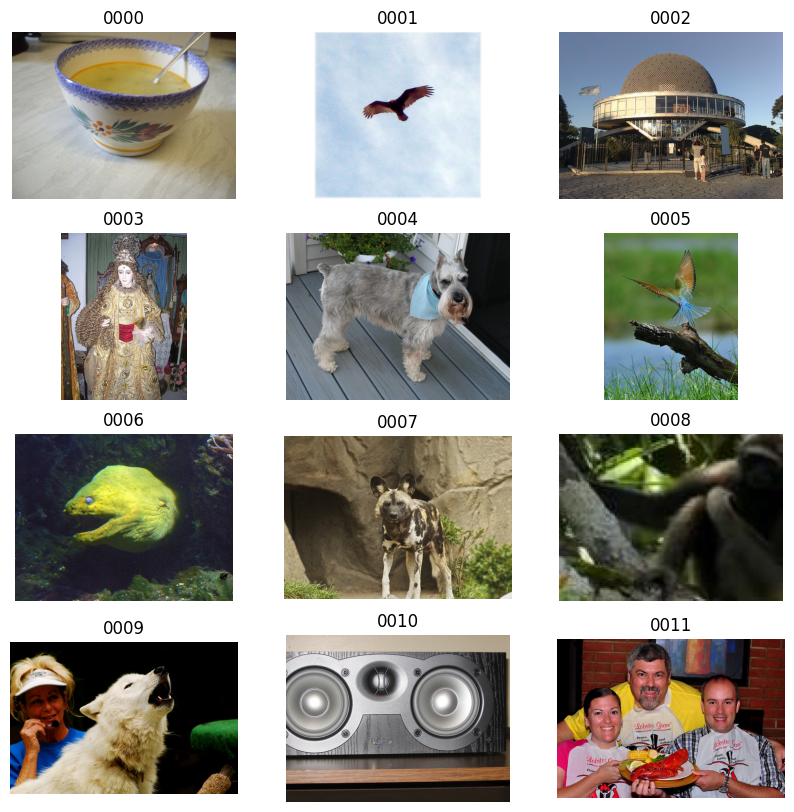

In [4]:
# prompt: Show some image from each class

import glob
import matplotlib.pyplot as plt
from PIL import Image
import random

# Get a list of all the image files in the dataset.
images = glob.glob('/content/imagenet/Train/val_images/*.JPEG')

# Create a figure with subplots to display the images.
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

# Select a random image from each class and display it.
ids = sorted(set([image.split('/')[-1][-10:-6] for image in images]))
for i, cls in enumerate(ids[0:12]):
  class_images = [image for image in images if image.split('/')[-1][-10:-6] == cls]
  random_image = random.choice(class_images)
  image = Image.open(random_image)
  axs[i // 3, i % 3].imshow(image)
  axs[i // 3, i % 3].set_title(cls)
  axs[i // 3, i % 3].axis('off')

# Show the plot.
plt.show()

In [5]:
# prompt: Use keras to load a pretrained convnext model

import keras
from keras.applications import ConvNeXtTiny
cn_model = ConvNeXtTiny(weights='imagenet')


114735104/114735104 [==============================] - 6s 0us/step


In [6]:
# Create a model that applies cn_model to the input, but takes the output
# of the previous to last layer and normalize it

notop_model = keras.Model(inputs=cn_model.inputs, outputs=cn_model.layers[-2].output)

x = notop_model.output
x = keras.layers.UnitNormalization()(x)
emb_model = keras.Model(inputs=notop_model.inputs, outputs=x)


In [7]:
# prompt: Load an image and apply both cn_model and emb_model
from keras.applications.resnet50 import decode_predictions
import numpy as np
image = Image.open('/content/imagenet/Train/val_images/ILSVRC2012_val_00000001.JPEG')
image = image.resize((224, 224))
# image = np.array(image) / 255.0 # WARNING: This is not needed since ConvNext preprocess the input

cn_output = cn_model.predict(np.expand_dims(image, axis=0))
emb_output = emb_model.predict(np.expand_dims(image, axis=0))


print('Class prediction:', np.argmax(cn_output), decode_predictions(cn_output, top=5))
print('Embedding shape:', emb_output.shape)


35363/35363 [==============================] - 0s 1us/step
Class prediction: 65 [[('n01751748', 'sea_snake', 0.9370061), ('n01744401', 'rock_python', 0.0054384526), ('n02526121', 'eel', 0.0020061706), ('n01737021', 'water_snake', 0.0019597998), ('n01740131', 'night_snake', 0.0007720486)]]
Embedding shape: (1, 768)


In [8]:
file = '/content/drive/MyDrive/CC_Thesis_DP/datasets/imagenet/val_labels_onlynums.txt'
#file = '/content/drive/MyDrive/Research/Thesis/CC_Thesis_DP/datasets/imagenet/val_labels_onlynums.txt'
#file.read_text()

    # Open the file in "read" mode ('r')
with open(file, 'r') as text:
    textfile = text.read()


textfile = textfile.split('\n')
textfile.pop()

labels = [eval(i) for i in textfile]

In [9]:
import tensorflow as tf

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagenet/Train/val_images',
    labels = labels[:45000],
    label_mode='int',
    batch_size=256,
    image_size=(224, 224),
    shuffle=False)

embds = []
y_labels = []
y_preds = []
for batch in iter(train_ds):
    print('.')  # progress bar
    imgs, y = batch
    emb = emb_model(imgs)
    embds.extend(emb)

Found 45000 files belonging to 1000 classes.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [10]:
embdsarr = np.array(embds)
embdsarr = embdsarr / np.linalg.norm(embdsarr, axis= -1, keepdims= True)
embdsarr.shape

(45000, 768)

In [11]:
np.linalg.norm(embdsarr[100])

1.0

In [32]:
# Create a KNN classifier with the weights

from sklearn.neighbors import KNeighborsClassifier

list_of_knns = []

for i in range(1,55):
  knn_model = KNeighborsClassifier(n_neighbors=i)
  knn_model.fit(embdsarr, labels[:embdsarr.shape[0]])
  list_of_knns.append(knn_model)

# test it with the embedding of the previous image
emb_output = emb_output / np.linalg.norm(emb_output)
distances, indices = knn_model.kneighbors(emb_output)
print(distances, indices)
pred_label = knn_model.predict(emb_output)
print(pred_label)

[[0.29581551 0.57491626 0.7214928  0.78622015 0.86071316 0.86303949
  0.86920783 0.87701259 0.88163263 0.88588181 0.90021591 0.9210803
  0.92781147 0.95431254 0.9565993  0.97518005 0.97702119 0.97987916
  0.98232207 0.98309185 0.98983537 0.98989935 0.99190896 0.99245599
  0.99383654 0.99491226 0.99671235 0.99715872 1.00843833 1.01805054
  1.02260154 1.03212158 1.03477534 1.03659188 1.03739428 1.04297927
  1.04305967 1.04720193 1.04978555 1.05000151 1.05173537 1.06103774
  1.06150249 1.06314511 1.06414919 1.06527253 1.06628579 1.06730525
  1.07179875 1.07220431 1.07398019 1.07398363 1.07451162 1.07451162]] [[    0 35364   323 21258 44383 25366 23137 20909 33902 15373  1694 33241
  35913 43835 21436  5131 16845 28502 19069 31059 25338 15751 19203  7557
  15691 16123     5 36290  8664 39264 33156  2697  5032 15595 43074 21331
   6816 11087 26711 21710 33263  9821 38122 32627 25095 37557 22922  1606
  40416 42351 20597 36189 23969 21872]]
[65]


In [13]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagenet/Test/val_images',
    labels = labels[45000:],
    label_mode='int',
    batch_size=256,
    image_size=(224, 224),
    shuffle=False)

Found 5000 files belonging to 995 classes.


In [33]:
y_preds = [[] for Null in range(len(list_of_knns))]

i = 0
for i, batch in enumerate(iter(test_ds)):
    imgs, y = batch
    emb = emb_model(imgs)
    emb = emb / np.linalg.norm(emb, axis= -1, keepdims= True)
    for j in range(len(list_of_knns)):
      distances, indices = list_of_knns[j].kneighbors(emb)
      y_preds[j].extend(np.take(labels, indices[:, 0]))



In [34]:
from sklearn.metrics import classification_report, accuracy_score

y_labels = np.array(labels[45000:])
accuracies = []

for preds in y_preds:
  preds = np.array(preds)
  accuracies.append(accuracy_score(y_labels, preds))

In [35]:
accuracies

[0.7672,
 0.7672,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.7672,
 0.7672,
 0.7672,
 0.7672,
 0.767,
 0.7672,
 0.767,
 0.767,
 0.7672,
 0.7672,
 0.767,
 0.767,
 0.767,
 0.767,
 0.7672,
 0.7672,
 0.7672,
 0.767,
 0.7672,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.767,
 0.7672,
 0.767,
 0.767,
 0.767,
 0.7672,
 0.7672,
 0.767,
 0.7672,
 0.767,
 0.767,
 0.7672,
 0.767,
 0.7672,
 0.767,
 0.767,
 0.767,
 0.767,
 0.7672,
 0.7672]